In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from scipy import stats

In [5]:
import warnings
warnings.filterwarnings("ignore")
sns.set(style = "whitegrid")

In [6]:
df = pd.read_csv("AIML Dataset.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [7]:
print("Distribution of Fraud Transactions")
print(df["isFraud"].value_counts())

print()

print("Distribution of Fraud Transactions that are Flagged")
print(df["isFlaggedFraud"].value_counts())


Distribution of Fraud Transactions
isFraud
0    6354407
1       8213
Name: count, dtype: int64

Distribution of Fraud Transactions that are Flagged
isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64


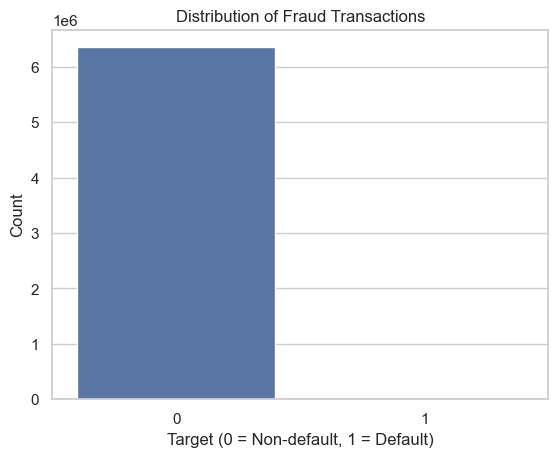

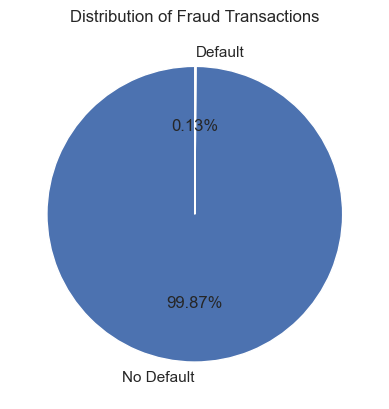

In [8]:
sns.countplot(x='isFraud', data=df)
plt.title("Distribution of Fraud Transactions")
plt.xlabel("Target (0 = Non-default, 1 = Default)")
plt.ylabel("Count")
plt.show()

df['isFraud'].value_counts(normalize=True).plot(kind='pie', autopct='%1.2f%%', labels=['No Default', 'Default'], startangle=90)
plt.title("Distribution of Fraud Transactions")
plt.ylabel("")
plt.show()


In [9]:
print("Number of NULL values in each row:")
number_of_na_data_values_each_row = df.isnull().sum()
print(number_of_na_data_values_each_row)
print()
print("Number of null values : ",number_of_na_data_values_each_row.sum())
if(number_of_na_data_values_each_row.sum() ==0):
    print("No Null values are present")


Number of NULL values in each row:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Number of null values :  0
No Null values are present


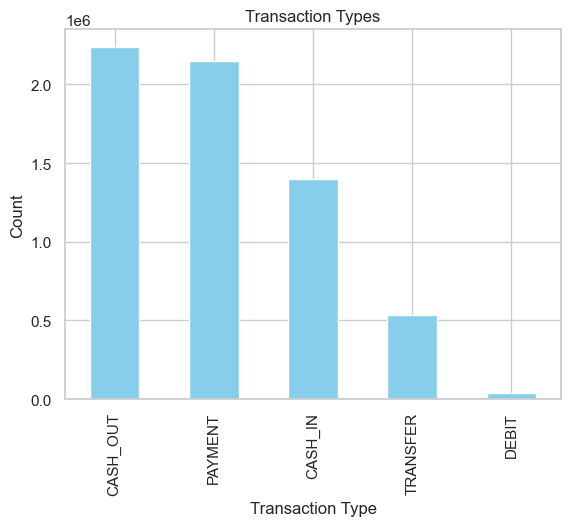

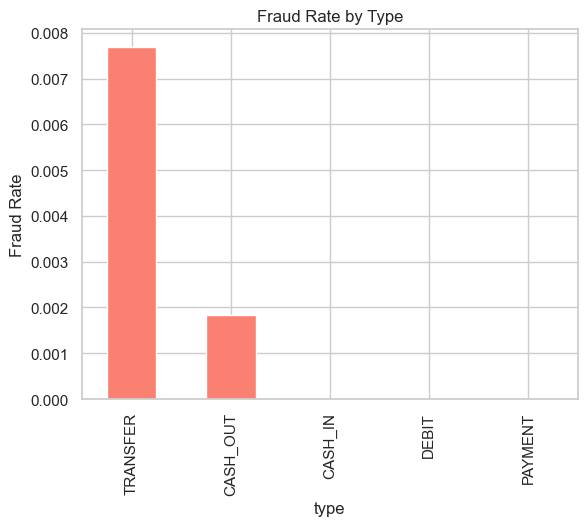

type
TRANSFER    0.007688
CASH_OUT    0.001840
CASH_IN     0.000000
DEBIT       0.000000
PAYMENT     0.000000
Name: isFraud, dtype: float64


In [10]:
df["type"].value_counts().plot(kind = "bar", title = "Transaction Types", color = "skyblue")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.show()

fraud_by_type = df.groupby("type")["isFraud"].mean().sort_values(ascending=False)
fraud_by_type.plot(kind = "bar", title = "Fraud Rate by Type", color = "salmon")
plt.ylabel("Fraud Rate")
plt.show()
print(fraud_by_type)



Text(0.5, 0, 'Log (Amount + 1)')

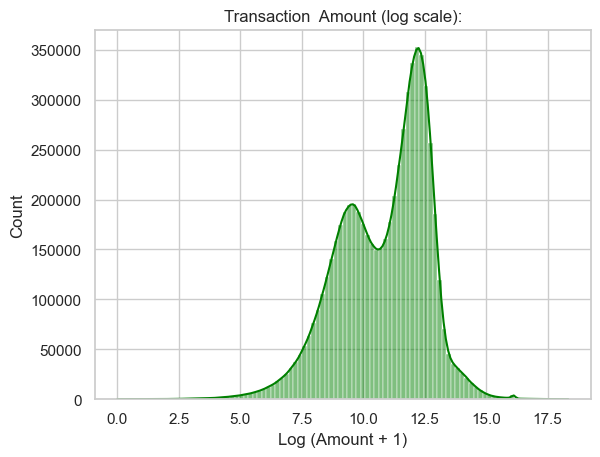

In [11]:
sns.histplot(np.log1p(df["amount"]), bins =100, kde = True, color="green")
plt.title("Transaction  Amount (log scale):")
plt.xlabel("Log (Amount + 1)")

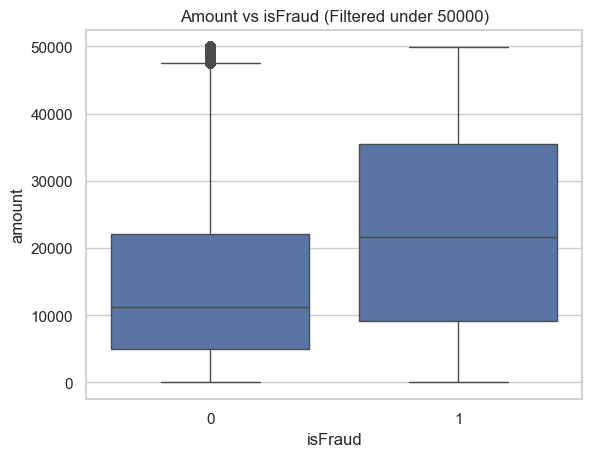

In [12]:
sns.boxplot(data = df[df["amount"]< 50000], x = "isFraud",y = "amount")
plt.title("Amount vs isFraud (Filtered under 50000)")
plt.show()

we can observe that there is more Fraud Rate when the amount is higher and lesser frauds (more non-fraud transactions) for lower amount. 

## Data Reduction

Dropping  "Step" column as fraud is independent of "Step" value (time)

In [13]:
df.drop(columns="step", inplace=True)
df.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Forming the correlation matrix to find if a relation between transaction details and if it is a fraud exists

The Correlation Matrix : 


,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
amount,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688
oldbalanceOrg,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154
newbalanceOrig,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148
oldbalanceDest,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885
newbalanceDest,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535
isFraud,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000


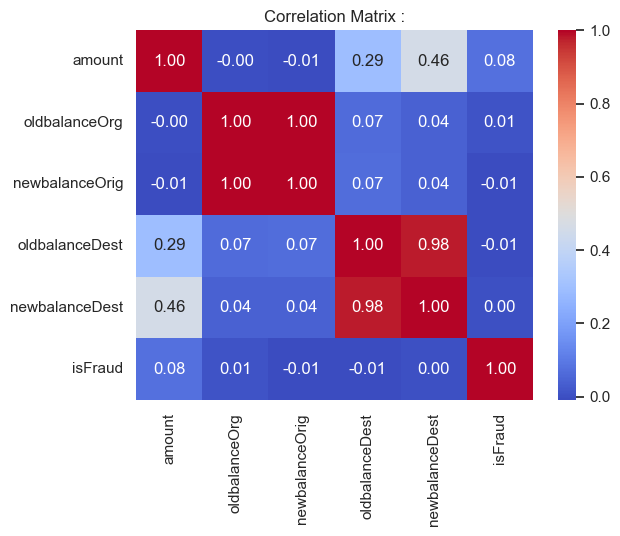

In [14]:
corr = df[["amount", "oldbalanceOrg", "newbalanceOrig","oldbalanceDest", "newbalanceDest","isFraud"]].corr()
print("The Correlation Matrix : ")
display(corr)

sns.heatmap(corr,annot = True, cmap = "coolwarm",fmt = ".2f")
plt.title("Correlation Matrix :")
plt.show()

we know that, if correlation value is negative means strong negative relationship (ie, one value decreases when the other increases), positive means strong positive relationship (ie, one value increases when the other value also increases) and value close to zero indicates independance 

Feature Engineering and Training the ML model

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [15]:
df.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Data Reduction


In [17]:
df_model = df.drop(["nameOrig","nameDest","isFlaggedFraud"], axis=1)

In [18]:
df_model.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


In [19]:
categorical = ["type"]
numeric = ["amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest"]

In [20]:
y = df_model["isFraud"]
x = df_model.drop("isFraud",axis =1)

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3, stratify=y)


## Data Normalization
StandardScaler() normalizes numeric features to have mean 0 and variance 1.


In [22]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num",StandardScaler(),numeric),
        ("cat",OneHotEncoder(drop="first"),categorical)
    ]
)

In [23]:
pipeline = Pipeline(
    [
        ("prep",preprocessor),
        ("clf", LogisticRegression(class_weight="balanced",max_iter=1000))
    ]
)

## Training the model

In [24]:
pipeline.fit(x_train,y_train)

,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [26]:
y_pred = pipeline.predict(x_test)

In [27]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97   1906322
           1       0.02      0.94      0.04      2464

    accuracy                           0.95   1908786
   macro avg       0.51      0.95      0.51   1908786
weighted avg       1.00      0.95      0.97   1908786



In [32]:
conf_mat = confusion_matrix(y_test,y_pred)
print("True Positives : ",conf_mat[0][0])
print("True Negatives : ",conf_mat[0][1])
print("False Positives : ",conf_mat[1][0])
print("False Negatives : ",conf_mat[1][1])

True Positives :  1804381
True Negatives :  101941
False Positives :  136
False Negatives :  2328


In [34]:
acc = pipeline.score(x_test,y_test)
print("The accuracy of the model is : ", acc*100,"%")

The accuracy of the model is :  94.65225541260257 %
